In [1]:
import numpy as np
from numpy import cos, sin, pi

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sympy as sp

In [2]:
def plot_robot(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    xs = [0]
    ys = [0]
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        xs.append(xs[-1] + l * cos(total_q))
        ys.append(ys[-1] + l * sin(total_q))
        
    plt.figure(figsize=(8,8))
    plt.plot(xs, ys)
    plt.ylim(-1 * total_len, total_len)
    plt.xlim(-1 * total_len, total_len)
    plt.title('Robot Manipulator Pose')
    
    return

In [3]:
def f_kine(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    x = 0
    y = 0
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        x += l * cos(total_q)
        y += l * sin(total_q)
        
    return np.array([[x],[y]])

In [4]:
def jacobian(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
            
    # Form symbolic q matrix
    
    qs = []
    
    for i in range(0,len(joints)):
        
        qs.append(sp.Symbol('q{}'.format(i)))
        
        
    jac = np.zeros((2, len(links)))
    
    x = 0
    y = 0
    
    # Form forward kinematics
    for i in range(len(links)):
                   
        total_q = 0
        
        for j in range(i + 1):
            
            total_q += qs[j]
            
        x += links[i] * sp.cos(total_q)
        y += links[i] * sp.sin(total_q)
        
    
    # Differentiate to find jacobian      
    for i in range(len(links)):
        
        Jx = sp.diff(x, qs[i])
        Jy = sp.diff(y, qs[i])
        
        for k in range(len(links)):
            
            Jx = Jx.subs(qs[k], joints[k])
            Jy = Jy.subs(qs[k], joints[k])
                
        jac[0,i] = Jx.evalf()
        jac[1,i] = Jy.evalf()
            
    return jac

In [5]:
# Note: this ONLY works for targets within the workspace. For points outside the workspace this function will not exit
def i_kine_null(links, joints, target, q_des, q_des_mask, error_trace=False):
    
    current_q = joints
    
    # This term limits the maximum delta x per move
    max_move = 2
    
    e_trace = []
    
    while(1):
        
        # Get the current end effector position
        current_x = f_kine(links, current_q)
        
        # Get the vector to the target
        delta_x = target - current_x
        
        # Find the magnitude of the movement required
        delta_x_norm = np.linalg.norm(delta_x)
        
        e_trace.append(delta_x_norm)
        
        # Limit the maximum magnitude of delta_x
        if (delta_x_norm > max_move):
            
            delta_x /= (delta_x_norm / max_move)
            
        q_err = np.multiply(q_des - current_q, q_des_mask)    

        # Stop if the end effector is sufficently close to target
        if (delta_x_norm < 0.001 and np.linalg.norm(q_err) < 0.01):
            
            break
            
        
        jac = jacobian(links, current_q)
        
        # Jacobian pseudoinversion
        jac_pinv = np.linalg.pinv(jac)
        
        # Find the required movements in the joint space
        alpha = 0.8
        delta_q = alpha * jac_pinv @ delta_x + (np.eye(len(current_q)) - jac_pinv @ jac) @ q_err
        
        # Add the change to find the updated joint angles
        current_q += delta_q
        
    return (current_q, e_trace) if error_trace else current_q

Text(0.5, 1.0, 'Error Trace')

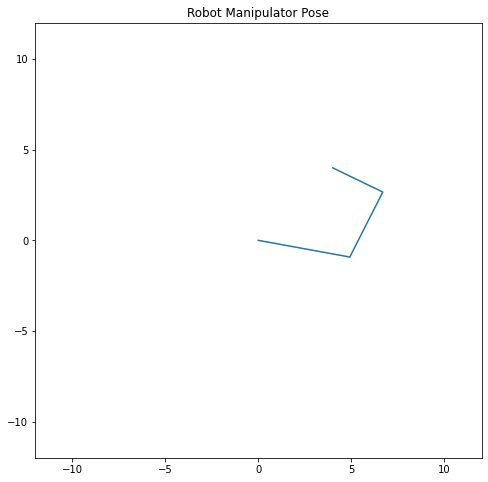

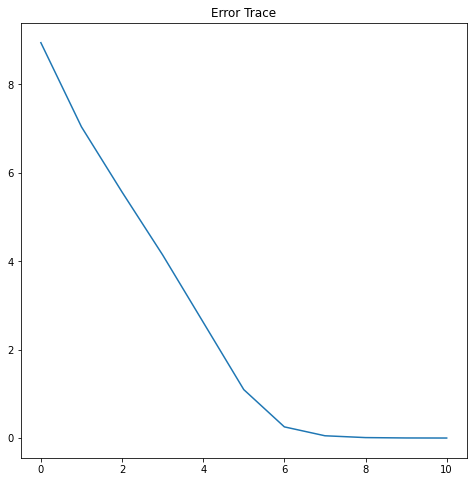

In [7]:
links = [5.0, 4.0, 3.0]
joints = np.array([[0.0],[0.0],[0.0]])
target = np.array([[4.0],[4.0]])

q_des = np.array([[0.0],[0.0],[pi/2]])
q_des_mask = np.array([[0],[0],[1]])

joints, e_trace = i_kine_null(links, joints, target, q_des, q_des_mask, error_trace=True)

plot_robot(links, joints)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')

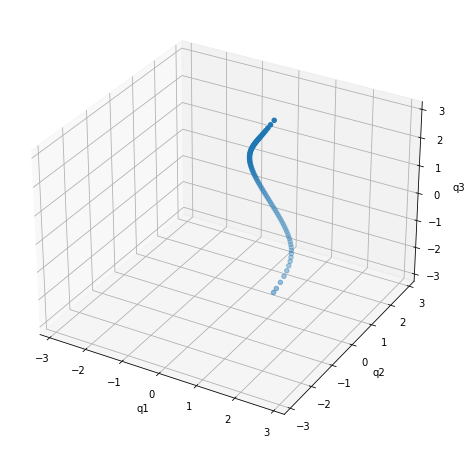

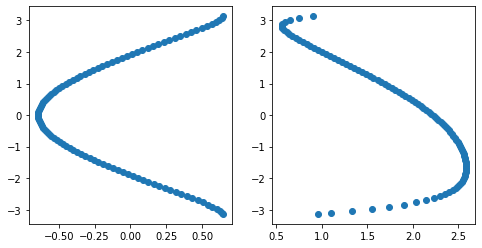

In [8]:
# We can use this to plot the self motion manifold in 3D space.

q1_null = []
q2_null = []
q3_null = []

for i in np.linspace(-pi, pi, 100):
        
    q_des = np.array([[0.0],[0.0],[i]])
    
    joints, e_trace = i_kine_null(links, joints, target, q_des, q_des_mask, error_trace=True)
    
    joints_list = np.squeeze(joints)
        
    q1_null.append(joints_list[0])
    q2_null.append(joints_list[1])
    q3_null.append(joints_list[2])
            
for i in range(len(q1_null)):
    
    q1_null[i] = (q1_null[i] + pi) % (2 * pi) - pi
    q2_null[i] = (q2_null[i] + pi) % (2 * pi) - pi
    q3_null[i] = (q3_null[i] + pi) % (2 * pi) - pi

        
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(-pi,pi)
ax.set_ylim3d(-pi,pi)
ax.set_zlim3d(-pi,pi)

ax.set_xlabel('q1')
ax.set_ylabel('q2')
ax.set_zlabel('q3')

ax.scatter(q1_null, q2_null, q3_null)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax1.scatter(q1_null, q3_null)

ax2 = fig.add_subplot(122)
ax2.scatter(q2_null, q3_null)